# 1d spectral extraction using simple summation and optimum spectral extraction

***

Author: Tri L. Astraatmadja, tastraatmadja@stsci.edu

This note demonstrates a simple method to recover a calibrated 1d spectrum of a point source, by using simple summation along the cross-dispersion axis. We'll use `sncosmo` to generate the spectrum of a Type Ia Supernova (without the host-galaxy. Let's keep things simple for now) and put it in the center of a datacube, which we'll pass to the <i>Ilia</i> simulator to generate <i>Roman</i> 2d spectral image. We'll then try to recover the original input 1d spectrum from the observed 2d spectrum.

Afterwards, we'll also demonstrate a technique called optimum spectral extraction <a href="https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract">(Horne 1986)</a> to do the same task and see what are the advantages of this technique compared to a simple summation.

Before we began, in order for this notebook to run properly, it is recommended to install the simulator `Ilia`. Follow the instructions on <a href="https://gitlab.com/astraatmadja/Ilia/-/blob/master/notebook/01%20-%20Ilia%20installation%20and%20demonstration.ipynb?ref_type=heads">this notebook</a>, download the relevant data files, and make sure everything runs.

In [2]:
from astropy import modeling
from astropy import units as u
from ilia import constants
from ilia.environment.scene import PointSourceScene
from ilia.instrument.disperser import RomanPrism
from ilia.instrument.throughput import RomanEffectiveArea
from ilia.simulator import RomanDisperserSimulator
from ilia.tools import plotting
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
from scipy import constants as sciconstants
from scipy import interpolate
import sncosmo
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
import synphot as syn

## Golden ratio
GOLDEN_RATIO = sciconstants.golden_ratio

LAMBDA_GRID = constants.LAMBDA_GRID

## Generating Supernova Ia spectrum using `sncosmo`

Let's use `sncosmo` to generate a supernova spectrum using the <a href="https://ui.adsabs.harvard.edu/abs/2007ApJ...663.1187H/abstract">Hsiao 2007</a> template. We'll use a relative "nearby" supernova at redshift $z=0.5$ and maximum time.

In [3]:
## Generate the supernova spectrum using sncosmo
# redshift
redshift = 0.5

## SN time from maximum
t0 = 0.0

## Initialize the model
model = sncosmo.Model(source='hsiao')

## Set the redshift and time since maximum
model.set(z=redshift, t0=t0)

## Normalize the SN such that it's absolute magnitude in the Bessell V-band is M_V = -19.5
model.set_source_peakabsmag(-19.5, 'bessellv', 'ab')

## Print the model parameters and magnitude to get a sense of how bright it is
for name in model.param_names:
    print(name, model[name])
print(model.bandmag('sdssz', 'ab', t0), model.bandflux('sdssz', t0))

## Here the output flux unit from sncosmo is FLAM (synphot lingo for ergs/s/cm2/A. FLAM = F lambda), so we'll attach that unit using synphot
sn_flux_flam = model.flux(t0, LAMBDA_GRID.to_value(u.angstrom)) * syn.units.FLAM

## We'll need the flux in PHOTLAM (photons/s/cm2/A) later for comparison with the recovered 1d spectrum, so we'll do unit conversion here,
## again using synphot
sn_flux_photlam = syn.units.convert_flux(LAMBDA_GRID, sn_flux_flam, syn.units.PHOTLAM)

z 0.5
t0 0.0
amplitude 7.836417804991638e-10
22.37681520385283 6.539716124861575e-05


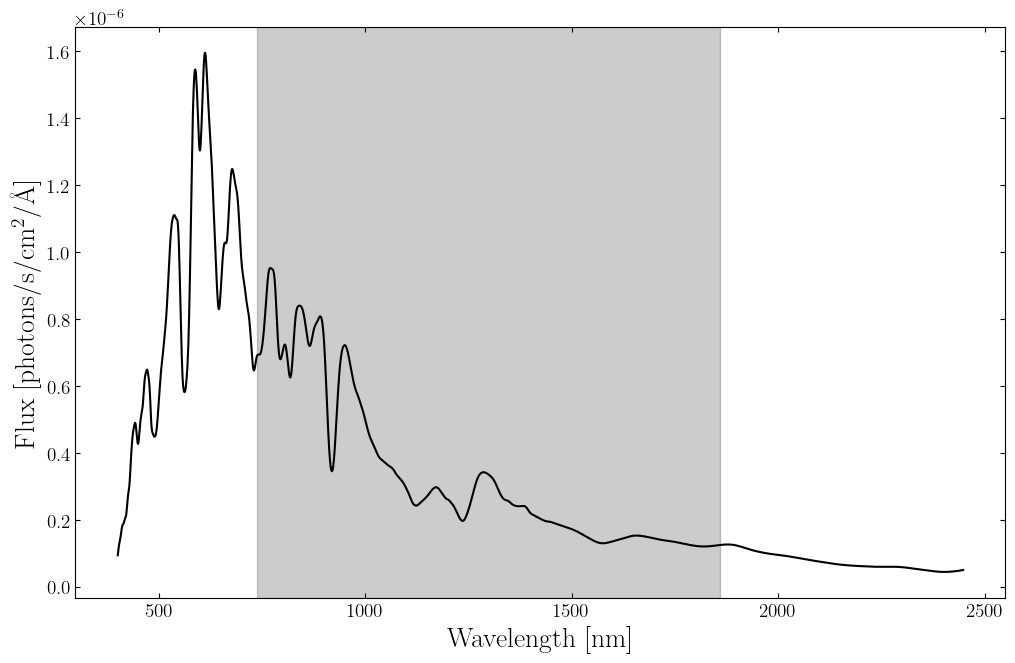

In [4]:
## Plot the spectrum, see if everything's alright
xSize = 12
ySize = xSize / GOLDEN_RATIO

opacity = 0.2

plotting.def_plot_values_extra_large()

fig = plt.figure(figsize=(xSize, ySize))

ax  = fig.add_subplot(111)

ax.plot(LAMBDA_GRID, sn_flux_photlam, 'k-')

yMin, yMax = ax.get_ylim()

## Draw the relevant spectral range of Roman prism
ax.fill_betweenx(np.array([yMin, yMax]), 738, x2=1859, color='black', alpha=opacity)

ax.set_ylim(yMin, yMax)

ax.set_xlabel(r'Wavelength [nm]')
ax.set_ylabel(r'Flux [photons/s/cm$^2$/\AA]');

Looks fine! Let's move on...

## Constructing the scene and simulating the 2d spectrum

We'll assume that host-galaxy of the supernova has been perfectly removed (I know it might be asking a lot to suspend the reader's disbelief on this matter, but hopefully for the purpose of this demonstration readers can do this). Since the supernova can be safely assumed to be a point source, we'll use the PointSourceScene class from `Ilia`, which only store the fluxes of the spectrum in a single point in a sparse matrix. This makes everything faster when we run the simulator.

In [5]:
## Constructing the datacube. We'll take it to be 51 x 51 Roman pixel and oversampled by a factor of 5
nPP, nQQ = 51, 51

oversample = 5

## We assume that the host-galaxy has been perfectly removed and what remains is the supernova, which can safely be assumed 
## to be a point source. Hopefully you can suspend your disbelief that we can perfectly remove the host-galaxy 
scene = PointSourceScene(nPP, nQQ, oversample, LAMBDA_GRID, sn_flux_flam)

nL, nP, nQ = scene.nL, scene.nP, scene.nQ

Now we have the scene and ready to run the simulator and generate a 2d spectrum. Let's define some observational parameters: The exposure time, the dithering, and the roll angle of the observations. Don't worry about the dither and roll angle, just set the exposure time to 30 minutes.

In [6]:
## Some parameters of the simulator
exposureTimeSp = 1800.0 * u.s ## Exposure time for spectroscopic observations

## Dither pattern: shift_x, shift_y, and angle
ditherPattern = [(0.0 * u.arcsec, 0.0 * u.arcsec, 0.0 * u.deg)]

In [7]:
## Fire up the simulator and generate the spectrum using the parameters above
simulator = RomanDisperserSimulator(disperser='prism', oversample=oversample)
hduList   = simulator.simulatePointSourceSpectra(scene, dithers=ditherPattern, exposureTime=exposureTimeSp)

hduList.info()

DITHER PATTERN 1/1: (0.000 arcsec, 0.000 arcsec, 0.000 deg), FRACTIONAL PIXEL SHIFT: 0.000 pix
DONE! ELAPSED TIME: 0 h 0 m 6.769 s
ALL DONE! ELAPSED TIME: 0 h 0 m 7.655 s
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SCI           1 ImageHDU        32   (51, 259)   float64   
  2  ERR           1 ImageHDU        32   (51, 259)   float64   
  3  TRUE          1 ImageHDU        32   (51, 259)   float64   
  4  WAVEPIX       1 BinTableHDU     18   208R x 1C   ['D']   
  5  BG            1 ImageHDU        12   (51, 259)   float64   


The simulator will generate an `astropy` HDUList object containing the observed image, error image (standard deviation of each measured pixel), as well as the noise-free image. In addition to these images, the wavelength will also be given, as well as the background image used to generate the sky noise.

Let's plot the 2d spectra images, both the noise-free and noisy data. Note that <i>Roman</i> prism disperse light along the $y$ axis in detector space. For illustration purpose, we'll transpose the image that it'll disperse horizontally.

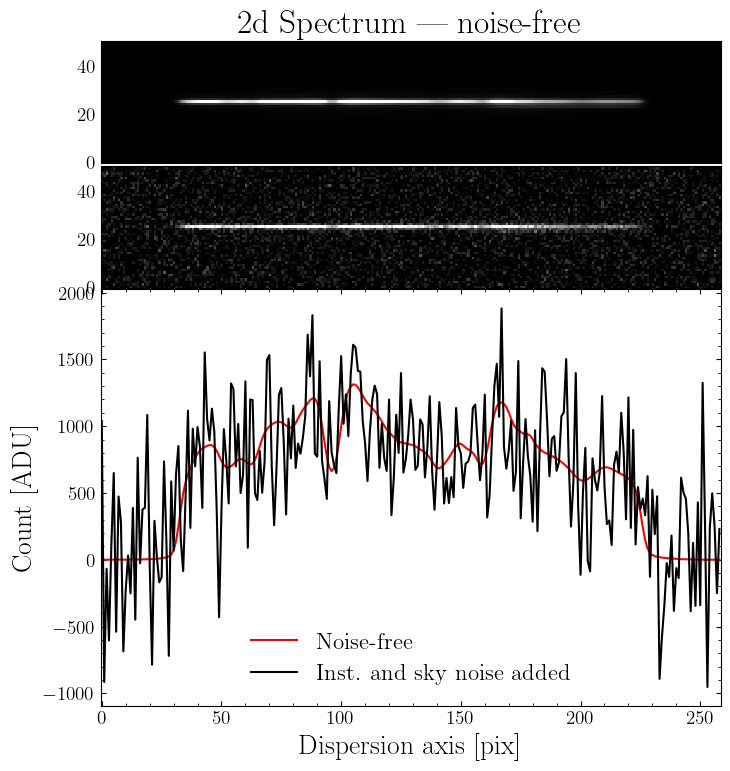

In [27]:
## Plot the 2d spectra images, the noise-free and the noisy data
nRows = 3
nCols = 1

xSize = 8
ySize = 1.75 * xSize/GOLDEN_RATIO

wspace = 0.00
hspace = 0.00

dX, dMX = 50, 10
dY, dMY = 20, 5

CI   = 99.0
P_HI = 0.5*(100.0 + CI)

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, height_ratios=[0.3, 0.3, 1], figsize=(xSize, ySize))

for k in range(2):
    ax = axes[k]

    ## Grab the noise-free image from the HDUList. Also sum the fluxes along the cross-dispersion axis to get a hang of what 
    ## the 1d spectrum would look like
    if (k == 0):
        title = '2d Spectrum --- noise-free'
        image = hduList['TRUE', 1].data.T
        
        spec1d_noiseFree = image.sum(0)

    ## Now we grab and display the noisy image.
    if (k == 1):
        title = '2d Spectrum --- inst. and sky noise added'
        image = hduList['SCI', 1].data.T

        spec1d_noisy = image.sum(0)
        
        ax.set_xlabel(r'Dispersion axis [pix]')
        
    vmin, vmax = 0.0, np.percentile(image, P_HI)

    ax.imshow(image, aspect='equal', cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='nearest')
        
    ax.set_title(title)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(dX))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(dMX))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(dY))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

    ## ax.set_ylabel(r'Spatial axis [pix]');

dY, dMY = 500, 100

axes[2].plot(spec1d_noiseFree, color='r', label='Noise-free')
axes[2].plot(spec1d_noisy, color='k', label='Inst. and sky noise added')

axes[2].legend(frameon=False, loc='best')

axes[2].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[2].set_xlabel(r'Dispersion axis [pix]')
axes[2].set_ylabel(r'Count [ADU]')

plt.subplots_adjust(wspace=wspace, hspace=hspace)

We're now going to extract 1d spectrum from the noisy image. We'll use several aperture width: $w = 1$ (just the central row), $w = 3$ (one row above and below the central row), and $w=11$ (five rows above and below the central row).

In [26]:
## Declare the half-width, which are 0, 1, and 5
dKs    = np.array([0, 1, 5], dtype=int)
colors = ['#7bccc4','#43a2ca','#0868ac']

25 233
0 25 25 26
1 25 24 27
5 25 20 31


Text(0, 0.5, 'Flux loss')

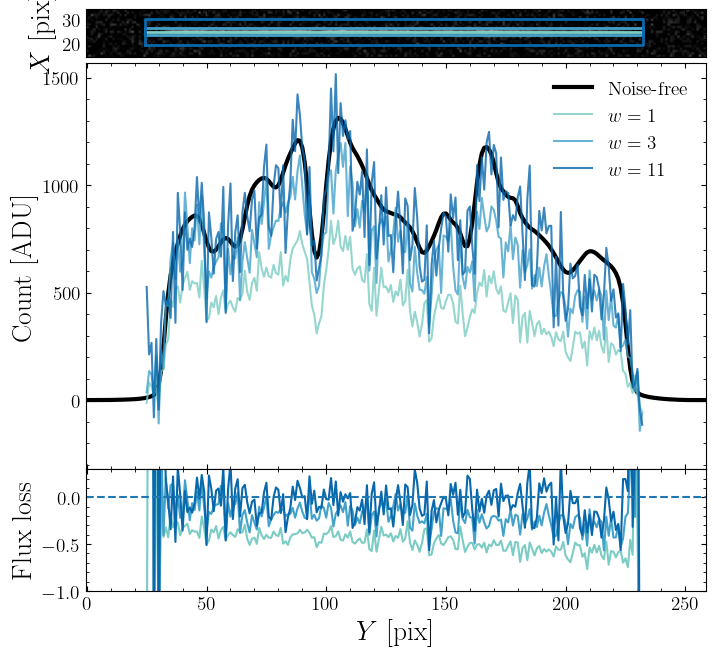

In [29]:
## Some plotting declarations
nCols = 1
nRows = 3

xSize = 8
ySize = 1.4 * xSize / GOLDEN_RATIO

CI  = 99.5
pHi = 0.5 * (100.0 + CI)

dCut = 10

opacity = 0.8

plotting.def_plot_values_extra_large()
                
fig, axes = plt.subplots(figsize=(xSize, ySize), ncols=nCols, nrows=nRows, sharex=True, sharey=False, height_ratios=[0.15, 1.0, 0.3])

plt.subplots_adjust(hspace=0.0, top=0.95, bottom=0.1)

dX, dMX = 50, 10
dY, dMY = 10, 2

## Grab the noisy image from the HDUList, and transpose so that the dispersion axis is along the horizontal axis
noisySpec = hduList['SCI'].data.T

## Get shape of the image
nK, nM = noisySpec.shape

## Find the zero-point of the extraction. The vertical zero-point is the central row, containing the object 
## which spectrum we want to extract. The horizontal zero-point is location of the reference wavelength, which
## is written in the header and (hopefully) is based on some calibration efforts
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

## This is the range of extraction along the dispersion axis, which is as long as the 
## wavelength array
xxMin, xxMax = x_c, x_c + hduList['WAVEPIX', 1].data['wavelength'].size

print(xxMin, xxMax)

## This is the pixel coordinate along the dispersion axis, but we only use the parts
## where there are non-zero fluxes from the source, and here it is based on the wavelength array
pixCoords = np.arange(nM, dtype=int)[xxMin:xxMax]
    
vmin = 0.0
vmax = np.nanpercentile(noisySpec, pHi)

axes[0].imshow(noisySpec, origin='lower', cmap='grey', aspect='equal', vmin=vmin, vmax=vmax)

axes[0].set_ylim(y_c - dCut - 0.5, y_c + dCut - 0.5)

## For comparisons between 1d extracted spectra, we'll grab the one-dimensional noise-free 1d spectrum
spec1dNoiseFree = hduList['TRUE'].data.sum(1)

axes[1].plot(spec1dNoiseFree, 'k-', label='Noise-free', linewidth=3)

for dK, color in zip(dKs, colors):
    yyMin = max(0,  y_c - dK)
    yyMax = min(nK, y_c + dK+1)

    print(dK, y_c, yyMin, yyMax)

    vertices = np.array([[xxMin-0.5, y_c], [xxMax-0.5, y_c]])

    if (dK > 0):
        vertices = np.array([[xxMin-0.5, yyMin-0.5],
                             [xxMin-0.5, yyMax-0.5],
                             [xxMax-0.5, yyMax-0.5],
                             [xxMax-0.5, yyMin-0.5]])
        vertices = np.vstack([vertices, vertices[0]])

    axes[0].plot(vertices[:,0], vertices[:,1], '-', color=color, linewidth=2)

    spec1dNoisy = noisySpec[yyMin:yyMax, xxMin:xxMax].sum(0)

    axes[1].plot(pixCoords, spec1dNoisy, '-', color=color, label='$w = '+'{0:d}'.format(2 * dK + 1)+'$', alpha=opacity)

    fluxLoss = (spec1dNoisy - spec1dNoiseFree[xxMin:xxMax]) / spec1dNoiseFree[xxMin:xxMax]

    axes[2].plot(pixCoords, fluxLoss, '-', color=color, label='$w = '+'{0:d}'.format(2 * dK + 1)+'$')

axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[0].set_ylabel(r'$X$ [pix]')

axes[1].yaxis.set_major_locator(ticker.MultipleLocator(500))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(100))

axes[1].set_ylim(-321.37194664311335, 1566.2893555278147)

axes[1].set_ylabel(r'Count [ADU]')
axes[1].legend(frameon=False, loc='upper right', fontsize='x-small')

axes[2].axhline(linestyle='--')

axes[2].set_ylim(-1.0, +0.3)

axes[2].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

axes[2].set_xlabel(r'$Y$ [pix]')
axes[2].set_ylabel(r'Flux loss')

In [ ]:


'''
nCols = 1
nRows = 3

xSize = 8
ySize = 1.4 * xSize / GOLDEN_RATIO

CI  = 99.5
pHi = 0.5 * (100.0 + CI)

dCut = 10

opacity = 0.8

for k in range(len(dKs)):
    plotting.def_plot_values_extra_large()
                    
    fig, axes = plt.subplots(figsize=(xSize, ySize), ncols=nCols, nrows=nRows, sharex=True, sharey=False, height_ratios=[0.15, 1.0, 0.3])
    
    plt.subplots_adjust(hspace=0.0, top=0.95, bottom=0.1)
    
    dX, dMX = 50, 10
    dY, dMY = 10, 2
    
    noisySpec = hduList['SCI'].data.T
    
    nK, nM = noisySpec.shape
    
    y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])
    
    xxMin, xxMax = x_c, x_c + hduList['WAVEPIX', 1].data['wavelength'].size
    
    print(xxMin, xxMax)
    
    pixCoords = np.arange(nM, dtype=int)[xxMin:xxMax]
        
    vmin = 0.0
    vmax = np.nanpercentile(noisySpec, pHi)
    
    axes[0].imshow(noisySpec, origin='lower', cmap='grey', aspect='equal', vmin=vmin, vmax=vmax)

    axes[0].set_ylim(y_c - dCut - 0.5, y_c + dCut - 0.5)
    
    spec1dNoiseFree = hduList['TRUE'].data.sum(1)
    
    axes[1].plot(spec1dNoiseFree, 'k-', label='Noise-free', linewidth=3)

    for kk in range(1, k+1):
        dK    = dKs[kk]
        color = colors[kk]

        yyMin = max(0,  y_c - dK)
        yyMax = min(nK, y_c + dK+1)
    
        print(dK, y_c, yyMin, yyMax)
    
        vertices = np.array([[xxMin-0.5, y_c], [xxMax-0.5, y_c]])
    
        if (dK > 0):
            vertices = np.array([[xxMin-0.5, yyMin-0.5],
                                 [xxMin-0.5, yyMax-0.5],
                                 [xxMax-0.5, yyMax-0.5],
                                 [xxMax-0.5, yyMin-0.5]])
            vertices = np.vstack([vertices, vertices[0]])
    
        axes[0].plot(vertices[:,0], vertices[:,1], '-', color=color, linewidth=2)
    
        spec1dNoisy = noisySpec[yyMin:yyMax, xxMin:xxMax].sum(0)
    
        axes[1].plot(pixCoords, spec1dNoisy, '-', color=color, label='$w = '+'{0:d}'.format(2 * dK + 1)+'$', alpha=opacity)
    
        fluxLoss = (spec1dNoisy - spec1dNoiseFree[xxMin:xxMax]) / spec1dNoiseFree[xxMin:xxMax]
    
        axes[2].plot(pixCoords, fluxLoss, '-', color=color, label='$w = '+'{0:d}'.format(2 * dK + 1)+'$')

    axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
    axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
    axes[0].yaxis.set_major_locator(ticker.MultipleLocator(dY))
    axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))
    
    axes[0].set_ylabel(r'$X$ [pix]')
    
    axes[1].yaxis.set_major_locator(ticker.MultipleLocator(500))
    axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(100))
    
    axes[1].set_ylim(-321.37194664311335, 1566.2893555278147)
    
    axes[1].set_ylabel(r'Count [ADU]')
    axes[1].legend(frameon=False, loc='upper right', fontsize='x-small')
    
    axes[2].axhline(linestyle='--')
    
    axes[2].set_ylim(-1.0, +0.3)
    
    axes[2].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    
    axes[2].set_xlabel(r'$Y$ [pix]')
    axes[2].set_ylabel(r'Flux loss')
    
    outFilename = "{0:s}/plot_1dSpectralExtraction_simpleSummation_{1:02d}.pdf".format(OUTDIR, k)
    fig.savefig(outFilename)
    ## fig.clf()
    ## plt.close(fig)
''';

In [ ]:
AEff  = RomanEffectiveArea()
prism = RomanPrism(oversample=1)

In [ ]:
wavePix = hduList['WAVEPIX', 1].data['wavelength'] * u.Unit(hduList['WAVEPIX', 1].header['TUNIT1'])

effArea    = AEff.getEffectiveArea(wavePix, 'prism')
dispersion = prism.getDispersionCurve(wavePix).to(u.angstrom / u.pix)

In [ ]:
wavePix

In [ ]:
dispersion

In [ ]:
## To compare between the extracted calibrated spectrum and the true supernova spectrum, we're going to re-use SNCosmo 
## to generate the true 1d spectra in wavePix grid

true1dSpec_resampled_flam = model.flux(t0, wavePix.to_value(u.angstrom)) * syn.units.FLAM
true1dSpec_resampled = syn.units.convert_flux(wavePix, true1dSpec_resampled_flam, syn.units.PHOTLAM)

In [ ]:
nRows = 2
nCols = 1

xSize = 8
ySize = 1.3 * xSize / GOLDEN_RATIO

xMin, xMax = 7000, 19000
dX, dMX = 2000, 500

yMin, yMax = 0.0, 1.e-6

opacity = 0.8

plotting.def_plot_values_extra_large()

fig = plt.figure(figsize=(xSize, ySize))

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, figsize=(xSize, ySize), height_ratios=[1.0, 0.3])

plt.subplots_adjust(hspace=0.0)

axes[0].plot(LAMBDA_GRID.to(u.angstrom), sn_flux_photlam, 'k-', label='True spectrum', linewidth=3)

noisySpec = hduList['SCI'].data.T

nK, nM = noisySpec.shape
    
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

xxMin, xxMax = x_c, x_c + hduList['WAVEPIX', 1].data['wavelength'].size

print(xxMin, xxMax)

axes[1].axhline(color='k', linestyle='--')

for dK, color in zip(dKs, colors):
    if (dK >= 0):
        yyMin = max(0,  y_c - dK)
        yyMax = min(nK, y_c + dK+1)
    
        print(dK, y_c, yyMin, yyMax)
    
        spec1dNoisy = noisySpec[yyMin:yyMax, xxMin:xxMax].sum(0) * u.adu / u.pix

        print(spec1dNoisy.shape)

        spec1d_cal_noisy = (spec1dNoisy / exposureTimeSp / effArea / dispersion) / (1.0 * u.adu / u.ph)

        axes[0].plot(wavePix, spec1d_cal_noisy, '-', color=color, label='$w = '+'{0:d}'.format(2 * dK + 1)+'$', alpha=opacity)

        fluxLoss = (spec1d_cal_noisy - true1dSpec_resampled) / true1dSpec_resampled

        axes[1].plot(wavePix, fluxLoss, '-', color=color, label='$w = '+'{0:d}'.format(2 * dK + 1)+'$', alpha=opacity)

axes[0].set_xlim(xMin, xMax)
axes[0].set_ylim(0.0, yMax)
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(2.0e-7))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.5e-7))

axes[0].legend(frameon=False)

dY, dMY = 0.5, 0.1

axes[1].axhline(linestyle='--', color='k')

axes[1].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[1].set_ylim(-1.0, +0.4)

axes[0].set_ylabel(r'Flux [photons/s/cm$^2$/\AA]')

axes[1].set_xlabel(r'Wavelength [\AA]')
axes[1].set_ylabel(r'Flux loss')

outFilename = "{0:s}/plot_1dSpectralExtraction_simpleSummation_calibrated.pdf".format(OUTDIR)
fig.savefig(outFilename, bbox_inches='tight')

In [ ]:
lorentzParameterFilename = "/Users/tastraatmadja/Research/roman/optimum_spectral_extraction/LSF_lorentzParameters_nPulse0022.csv"

df = pd.read_csv(lorentzParameterFilename)## .drop(index=[19,20,21]) ## .drop(index=[1,4,5,6,13])

wave  = (df['wavelength'].values * u.nanometer).to(u.angstrom)
gamma = df['gamma'].values

f = interpolate.interp1d(wave, gamma, kind='quadratic', fill_value='extrapolate')

In [ ]:
xSize = 8
ySize = xSize / GOLDEN_RATIO

plotting.def_plot_values_extra_large()
fig = plt.figure(figsize=(xSize, ySize))
ax  = fig.add_subplot(111)

ax.plot(wave, gamma, 'ko-')

yMin, yMax = ax.get_ylim()

ax.plot(wavePix,f(wavePix.value), 'r-')

## ax.set_ylim(yMin, yMax)

ax.set_ylim(0.5, 2.0)

In [ ]:
hduList.info()

In [ ]:
obsID = 1

nRows = 2
nCols = 1

xSize = 8
ySize = 1.3 * xSize / GOLDEN_RATIO

xMin, xMax = 7000, 19000
dX, dMX = 2000, 500

yMin, yMax = 0.0, 1.e-6

opt_color = '#7570b3'

plotting.def_plot_values_extra_large()

fig = plt.figure(figsize=(xSize, ySize))

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, figsize=(xSize, ySize), height_ratios=[1.0, 0.3])

plt.subplots_adjust(hspace=0.0)

axes[0].plot(LAMBDA_GRID.to(u.angstrom), sn_flux_photlam, 'k-', label='True spectrum', linewidth=3)

noisySpec = hduList['SCI', obsID].data.T
varImage  = hduList['ERR', obsID].data.T ** 2
shiftY    = float(hduList['SCI', obsID].header['shift_y']) * u.arcsecond
tExp      = float(hduList['SCI', obsID].header['exptime']) * u.s

nK, nM = noisySpec.shape
    
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

xxMin, xxMax = x_c, x_c + hduList['WAVEPIX', 1].data['wavelength'].size

print(xxMin, xxMax)

pixCoords = np.arange(nK, dtype=float) - y_c

axes[1].axhline(color='k', linestyle='--')

for dK, color in zip(dKs, colors):
    if (dK >= 0):
        yyMin = max(0,  y_c - dK)
        yyMax = min(nK, y_c + dK+1)
    
        print(dK, y_c, yyMin, yyMax)
    
        spec1dNoisy = noisySpec[yyMin:yyMax, xxMin:xxMax].sum(0) * u.adu / u.pix

        print(spec1dNoisy.shape)

        spec1d_cal_noisy = (spec1dNoisy / exposureTimeSp / effArea / dispersion) / (1.0 * u.adu / u.ph)

        axes[0].plot(wavePix, spec1d_cal_noisy, '-', color=color, label='$w = '+'{0:d}'.format(2 * dK + 1)+'$', alpha=opacity)

        fluxLoss = (spec1d_cal_noisy - true1dSpec_resampled) / true1dSpec_resampled

        axes[1].plot(wavePix, fluxLoss, '-', color=color, label='$w = '+'{0:d}'.format(2 * dK + 1)+'$', alpha=opacity)

dK = np.inf

yyMin = max(y_c-dK, 0)     ## Inclusive
yyMax = min(y_c+dK+1, nK) ## EXCLUSIVE. So add an additional 1 pixel

spec1d_opt_noisy = np.zeros(wavePix.size)

gammaInterp = np.zeros(wavePix.size)
weights     = np.zeros((wavePix.size, nPP))

for l in range(wavePix.size):
    gammaInterp[l] = f(wavePix[l].value)

    model = modeling.models.Lorentz1D(x_0=(shiftY / constants.ROMAN_PIXSCALE).value, amplitude=1.0, fwhm=gammaInterp[l])

    weights[l] = model(pixCoords)

    weights[l] = weights[l] / weights[l, yyMin:yyMax].sum()

    spec1d_opt_noisy[l] = np.sum(weights[l, yyMin:yyMax] * noisySpec[yyMin:yyMax,l+xxMin] / varImage[yyMin:yyMax,l+xxMin]) / np.sum(weights[l, yyMin:yyMax]**2 / varImage[yyMin:yyMax,l+xxMin])

    spec1d_opt_noisy[l] = (spec1d_opt_noisy[l] / tExp / effArea[l] / dispersion[l]).value

spec1d_opt_noisy *= syn.units.PHOTLAM

fluxLoss_opt = (spec1d_opt_noisy - true1dSpec_resampled) / true1dSpec_resampled

axes[0].plot(wavePix.to(u.angstrom), spec1d_opt_noisy, '-', color=opt_color, label='Optimum spectral extraction', linewidth=3, alpha=opacity)
axes[1].plot(wavePix.to(u.angstrom), fluxLoss_opt, '-', color=opt_color, linewidth=3, alpha=opacity)

axes[0].set_xlim(xMin, xMax)
axes[0].set_ylim(0.0, yMax)
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(2.0e-7))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.5e-7))

axes[0].legend(frameon=False)

dY, dMY = 0.5, 0.1

axes[1].axhline(linestyle='--', color='k')

axes[1].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[1].set_ylim(-1.0, +0.4)

axes[0].set_ylabel(r'Flux [photons/s/cm$^2$/\AA]')

axes[1].set_xlabel(r'Wavelength [\AA]')
axes[1].set_ylabel(r'Flux loss')

outFilename = "{0:s}/plot_1dSpectralExtraction_optimumSpectralExtraction_calibrated.pdf".format(OUTDIR)
fig.savefig(outFilename, bbox_inches='tight')